<a href="https://colab.research.google.com/github/pachterlab/monod/blob/anndata/Monod_demo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset.

# Inference pipeline

## Import prerequisites

In [1]:
!pip install scanpy

In [5]:
!pip install loompy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 65.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52019 sha256=ac2ad9da9eb5409ae70f910f682af531ea72388a4c7bdd43ea0f29ccfbfbd66d
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
Successfully built loompy


## Install monod

In [1]:
!git clone -b anndata --single-branch https://github.com/pachterlab/monod.git

Cloning into 'monod'...
remote: Enumerating objects: 1097, done.
remote: Counting objects: 100% (526/526), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 1097 (delta 424), reused 404 (delta 354), pack-reused 571 (from 1)
Receiving objects: 100% (1097/1097), 22.34 MiB | 9.19 MiB/s, done.
Resolving deltas: 100% (635/635), done.
Updating files: 100% (32/32), done.


Let's make sure that the version is correct.

In [1]:
import sys
# sys.path.insert(0, 'monod/src/monod')
sys.path.insert(0, 'src/monod')


import extract_data, cme_toolbox, inference, analysis, mminference

## Import data

In [7]:
! git clone https://github.com/pachterlab/monod_examples.git

Cloning into 'monod_examples'...
remote: Enumerating objects: 1492, done.
remote: Counting objects: 100% (433/433), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 1492 (delta 192), reused 399 (delta 181), pack-reused 1059 (from 1)
Receiving objects: 100% (1492/1492), 1.07 GiB | 23.52 MiB/s, done.
Resolving deltas: 100% (536/536), done.
Updating files: 100% (92/92), done.


## Import other packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import anndata
from IPython.display import display, Markdown
import scanpy as sc
import random

In [3]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

## Knee plot and filter.

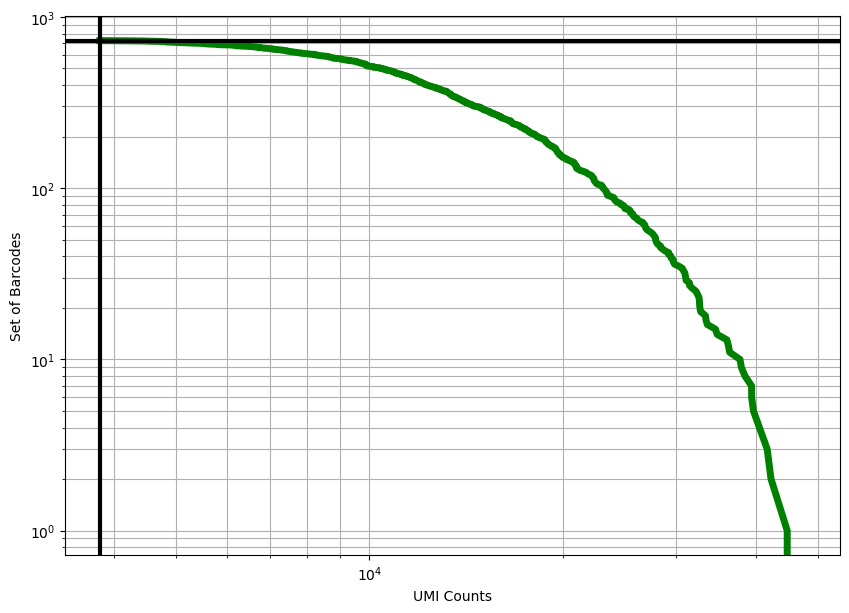

In [4]:
# Load anndata.
gaba_adata = anndata.read_h5ad('./gaba_example.h5ad')
gaba_adata.var_names_make_unique()

# Create knee plot. (Example data is already filtered, but adjust for other data.)
expected_num_cells =  727 # @param {type:"integer"}
knee = np.sort((np.array(gaba_adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

sc.pp.filter_cells(gaba_adata, min_genes=100)
# sc.pp.filter_genes(gaba_adata, min_cells=3)

In [21]:
## Optionally for meK-means, filter for highly variable genes. Taken from meK-Means example notebook.

S = gaba_adata.layers['spliced'][:,:].toarray()
U = gaba_adata.layers['unspliced'][:,:].toarray()
g_names = gaba_adata.var_names

def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S: cellxgene count matrices
    var_t: dispersion threshold
    u_min: minumum U average count
    s_min: minumum S average count
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    u_min = u_min
    s_min =  s_min

    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4)

    return fitted_idx

## Note that the anndata matrices are cellxgene, in contrast to meK-Means example.
#Filter for genes that pass thresholds
fitted_idx = nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02)
print('No. all genes that pass thresh: ', np.sum(fitted_idx))

#Get HVGs by standard methods
X=S  #May be better to use U.T for nuclear, snRNAseq, data
adata = anndata.AnnData(X=X)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

g_names_toUse = g_names[fitted_idx & adata.var.highly_variable]
print('No. of genes in 2k HVGs that pass filter: ',len(g_names_toUse))

No. all genes that pass thresh:  1512
No. of genes in 2k HVGs that pass filter:  668


## Set up model and perform inference.

In [5]:
# Define model.
fitmodel = cme_toolbox.CMEModel('Bursty','Poisson')
transcriptome_filepath = './monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

n_genes = 5
demo_genes = ['Eif5b','Xrcc5',	'Klhl12','Rgs7','Thsd7b']
all_DE = ['Rcan3', 'Rspo3', 'Vrk1', 'Tcerg1l', 'Clic4', 'Hcrtr2', '1110004F10Rik', 'Erbin', 'Lrp12', 'Gatm', 'Rims3']
# hv_genes = random.sample(list(g_names_toUse), n_genes)

# Perform inference. (don't need to give these bounds, here for debugging but can use defaults.)
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
# samp_lb, samp_ub = [-8, -3],[-5, 0]
# grid = [6,7]

## Fix sampling parameters to the ones given in the other Monod example.
samp_lb, samp_ub = [-6.8, -1.5],[-6.9, -1.6]
grid = [1,1]

# TODO: make 'nascent', 'mature' automatically recognized.
# './gaba_example.h5ad'
mek_means_params = (4,2) # Set to none if not using meK-Means

# TODO: fix number of genes selected (no longer getting to total every time).
gaba_adata = inference.perform_inference(gaba_adata, fitmodel, n_genes=n_genes, seed=5, genes_to_fit=demo_genes,
            phys_lb=lb, phys_ub=ub, gridsize=grid, samp_lb=samp_lb, samp_ub=samp_ub,
            gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1},
                                         transcriptome_filepath=transcriptome_filepath, poisson_average_log_length=5, dataset_string='new_gaba', viz=False,
                                         num_cores=8, mek_means_params=mek_means_params)

The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:Directory new_gaba already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: new_gaba
is sparse
INFO:root:Added lengths
INFO:root:728 cells detected.
3578 genes retained after expression filter.
INFO:root:0 random genes selected.
INFO:root:Total of 5 genes selected.
['unspliced', 'spliced'] previous ordering
['unspliced', 'spliced'] ordered for histogram
INFO:root:Data extracted
LayersView with keys: unspliced, spliced
['unspliced', 'spliced']
INFO:root:Search data created.
INFO:root:Directory new_gaba/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to new_gaba/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-parallelized grid

/home/cat/.conda/envs/myenv/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2679267) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 22.93it/s]

INFO:root:Parallelized MLE fits complete.


INFO:root:EM Epoch 1/2: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 21.38it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2371692  0.29754231 0.22308812 0.24220037]
Q Function:  -12447.908645054828

INFO:root:EM Epoch 2/2: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 22.81it/s]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.22023086 0.36847157 0.18667701 0.22462056]
Q Function:  -12094.291118492727

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory new_gaba/Bursty_Poisson_1x1/analysis_figures_0 already exists.
INFO:root:Directory new_gaba/Bursty_Poisson_1x1/analysis_figures_1 already exists.
INFO:root:Directory new_gaba/Bursty_Poisson_1x1/analysis_figures_2 already exists.
INFO:root:Directory new_gaba/Bursty_Poisson_1x1/analysis_figures_3 already exists.
INFO:root:Runtime: 1.1 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved.
INFO:root:AIC values calculated.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.


/home/cat/monod/src/monod/inference.py:171: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  monod_adata.var["cluster_{}_param_".format(j) + param_name] = param_values


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 0.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.4 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Gene 2 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 0.6 seconds.
INFO:root:Uncertainties per gene calculated.
Saving clusters


/home/cat/monod/src/monod/mminference.py:2144: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Directory glu_example already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: glu_example
INFO:root:Duplicate variable names found. Making them unique...
is sparse
INFO:root:Added lengths


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


INFO:root:6629 cells detected.
5520 genes retained after expression filter.
INFO:root:0 random genes selected.
INFO:root:Total of 5 genes selected.
['unspliced', 'spliced'] previous ordering
['unspliced', 'spliced'] ordered for histogram
INFO:root:Data extracted
LayersView with keys: unspliced, spliced
['unspliced', 'spliced']
INFO:root:Search data created.
INFO:root:Directory glu_example/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to glu_example/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:EM Epoch 1/2: 
mstep self.weights:  [0.25288529 0.2196231  0.27491167 0.25257994]
Q Function:  -113338.3265942548

INFO:root:EM Epoch 2/2: 
mstep self.weights:  [0.28002378 0.2572466  0.02444389 0.43828573]
Q Function:  -113601.41920510988

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory glu_example/Bursty_Poisson_1x1/analysis_

/home/cat/monod/src/monod/inference.py:171: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  monod_adata.var["cluster_{}_param_".format(j) + param_name] = param_values


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.4 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 0.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.9 seconds.
INFO:root:Uncertainties per gene calculated.
Saving clusters


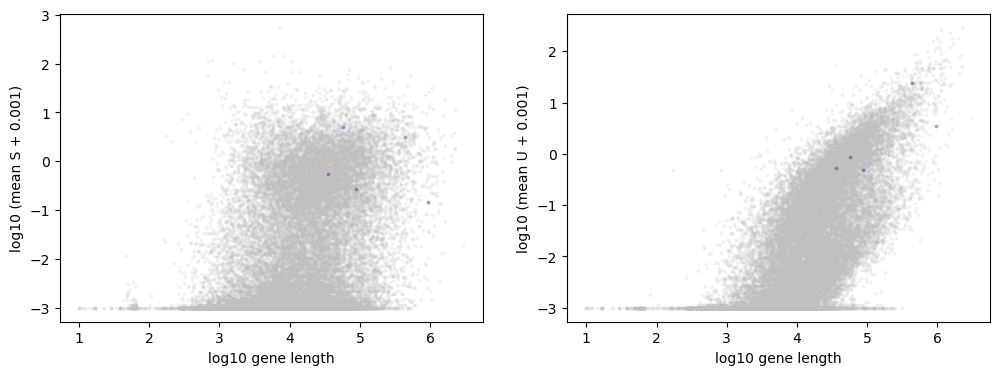

In [6]:
# Fix the genes to be the same as for the gaba data.
genes_to_fit = [i for i in gaba_adata.var_names]
n_genes = len(genes_to_fit)

glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=n_genes, seed=4, genes_to_fit=genes_to_fit,
                                       phys_lb=lb, phys_ub=ub, gridsize=grid, samp_lb=samp_lb, samp_ub=samp_ub,
                                        gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1},
                                       transcriptome_filepath=transcriptome_filepath, mek_means_params=mek_means_params) #['Eif5b', 'Thsd7b', 'Fbxw2', 'Otud7a', 'Asah1'])glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=5, seed=4, genes_to_fit=DE_genes,

In [ ]:
# # NB currently can't save whole object to file since some .uns attributes cannot be pickled.
# gaba_adata.write('gaba_fit.h5ad')
# gaba_adata.write('glu_fit.h5ad')

## Access gene info.

In [7]:
# AIC.
display(gaba_adata.var[['AIC']])

# Optimum biological parameters.
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'param' in i]])

# Uncertainties from Hessian.
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'sigma' in i]])

if mek_means_params:
    display(gaba_adata.obs)

,AIC
gene_name,
Eif5b,4969.559760
Xrcc5,2381.650922
Klhl12,2419.503282
Rgs7,8092.472083
Thsd7b,3908.289423


,cluster_0_param_$\log_{10} b$,cluster_1_param_$\log_{10} b$,cluster_2_param_$\log_{10} b$,cluster_3_param_$\log_{10} b$,cluster_0_param_$\log_{10} \beta$,cluster_1_param_$\log_{10} \beta$,cluster_2_param_$\log_{10} \beta$,cluster_3_param_$\log_{10} \beta$,cluster_0_param_$\log_{10} \gamma$,cluster_1_param_$\log_{10} \gamma$,cluster_2_param_$\log_{10} \gamma$,cluster_3_param_$\log_{10} \gamma$
gene_name,,,,,,,,,,,,
Eif5b,1.567979,1.709565,1.420600,1.799266,-0.365503,-0.350278,-0.357130,-0.059781,-0.369685,-0.431575,-0.566865,-0.058104
Xrcc5,-0.161865,1.302207,2.084836,1.671530,0.992850,-0.737198,0.121089,0.701880,0.638585,-0.083097,0.978687,1.480083
Klhl12,0.674554,1.868176,0.465916,1.616097,-1.612751,-0.254174,-1.536133,2.239811,-0.668881,0.631138,-0.739028,2.558949
Rgs7,1.948527,2.474719,2.152483,1.794641,-0.436760,-0.186330,-0.227519,-0.410946,0.320360,0.491983,0.426476,0.278018
Thsd7b,1.965223,1.562176,3.267050,1.386829,0.152258,-0.055437,2.322944,0.081113,1.146999,0.690292,3.411785,0.999605


,cluster_0_sigma_$\log_{10} b$,cluster_0_sigma_$\log_{10} \beta$,cluster_0_sigma_$\log_{10} \gamma$,cluster_1_sigma_$\log_{10} b$,cluster_1_sigma_$\log_{10} \beta$,cluster_1_sigma_$\log_{10} \gamma$,cluster_2_sigma_$\log_{10} b$,cluster_2_sigma_$\log_{10} \beta$,cluster_2_sigma_$\log_{10} \gamma$,cluster_3_sigma_$\log_{10} b$,cluster_3_sigma_$\log_{10} \beta$,cluster_3_sigma_$\log_{10} \gamma$
gene_name,,,,,,,,,,,,
Eif5b,0.119813,0.118118,0.119336,0.075120,0.075285,0.074688,0.134915,0.135447,0.134208,0.088128,0.084036,0.087378
Xrcc5,4.430857,4.492809,4.431282,0.130197,0.127636,0.131926,0.095565,0.081335,0.104840,0.220292,0.191950,0.256510
Klhl12,0.460034,0.458846,0.461561,0.111354,0.106381,0.114617,0.629398,0.628061,0.630789,0.111592,0.099143,0.136933
Rgs7,0.067758,0.061108,0.072813,0.042509,0.037081,0.042328,0.060987,0.053338,0.063721,0.060679,0.055988,0.066743
Thsd7b,0.070182,0.051788,0.101903,0.050575,0.043162,0.072990,0.369290,0.243669,0.320749,0.077268,0.064599,0.137103


,n_genes,cluster
barcode,,
AAACCCAAGCTATCCA,2652,2
AAAGAACTCTACCACC,5653,0
AAAGGATAGGTCATAA,3518,3
AAAGGGCCATTGAAAG,5412,2
AAAGGGCTCGGCTGTG,6080,0
...,...,...
TTTCACACACGCTTAA,6574,1
TTTCAGTCAATAGTCC,4334,3
TTTCCTCAGACGACGT,4334,1


In [8]:
# AIC.
display(glu_adata.var[['AIC']])

# Optimum biological parameters.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'param' in i]])

# Uncertainties from Hessian.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'sigma' in i]])

,AIC
gene_name,
Eif5b,49857.411552
Xrcc5,20148.521348
Klhl12,21186.010134
Rgs7,80981.945756
Thsd7b,29602.460586


,cluster_0_param_$\log_{10} b$,cluster_1_param_$\log_{10} b$,cluster_2_param_$\log_{10} b$,cluster_3_param_$\log_{10} b$,cluster_0_param_$\log_{10} \beta$,cluster_1_param_$\log_{10} \beta$,cluster_2_param_$\log_{10} \beta$,cluster_3_param_$\log_{10} \beta$,cluster_0_param_$\log_{10} \gamma$,cluster_1_param_$\log_{10} \gamma$,cluster_2_param_$\log_{10} \gamma$,cluster_3_param_$\log_{10} \gamma$
gene_name,,,,,,,,,,,,
Eif5b,1.693350,1.632380,1.697104,1.695712,-0.154302,-0.305651,-0.298774,-0.361132,-0.428740,-0.540721,-0.536176,-0.581695
Xrcc5,0.770588,1.069279,1.065671,1.492431,-0.173915,-0.520106,-1.458276,-0.165390,0.197312,0.084446,-0.492151,0.468608
Klhl12,1.275481,2.475754,1.276451,0.418641,-0.630846,2.324929,-0.738872,-1.800000,0.070023,3.500000,-0.182428,-1.051627
Rgs7,2.047542,2.084515,2.306992,2.275037,-0.467517,-0.403761,-0.417630,-0.324145,0.076919,0.145071,0.317737,0.228767
Thsd7b,3.052513,1.591870,1.647377,1.624460,2.500000,0.182948,0.264572,0.076960,3.466164,0.877209,1.134217,0.797739


,cluster_0_sigma_$\log_{10} b$,cluster_0_sigma_$\log_{10} \beta$,cluster_0_sigma_$\log_{10} \gamma$,cluster_1_sigma_$\log_{10} b$,cluster_1_sigma_$\log_{10} \beta$,cluster_1_sigma_$\log_{10} \gamma$,cluster_2_sigma_$\log_{10} b$,cluster_2_sigma_$\log_{10} \beta$,cluster_2_sigma_$\log_{10} \gamma$,cluster_3_sigma_$\log_{10} b$,cluster_3_sigma_$\log_{10} \beta$,cluster_3_sigma_$\log_{10} \gamma$
gene_name,,,,,,,,,,,,
Eif5b,0.026837,0.026984,0.026563,0.027735,0.027689,0.027553,0.266829,0.263044,0.265412,0.021705,0.021562,0.021589
Xrcc5,0.158003,0.155903,0.158719,0.081920,0.081048,0.082948,0.479165,0.474528,0.485876,0.036905,0.035590,0.038814
Klhl12,0.083848,0.083076,0.084453,0.325401,0.157831,0.274955,0.609521,0.601580,0.604855,0.120031,0.119822,0.120244
Rgs7,0.016758,0.015637,0.017299,0.016179,0.014916,0.016724,0.195931,0.148018,0.196901,0.012851,0.011660,0.013031
Thsd7b,0.169173,0.055523,0.120436,0.021640,0.017005,0.030857,0.300465,0.205697,0.395996,0.016399,0.013198,0.023144


## Plot parameter distributions.

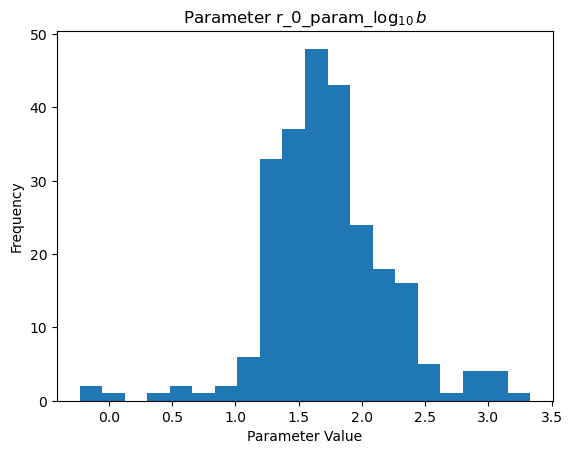

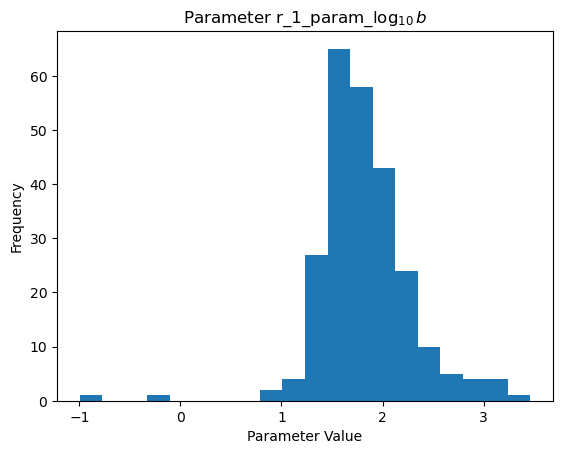

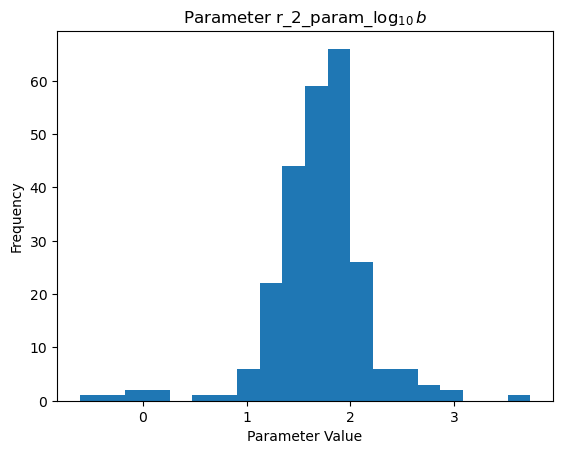

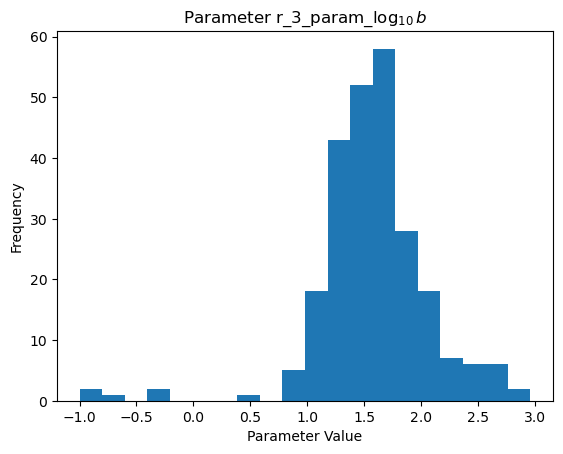

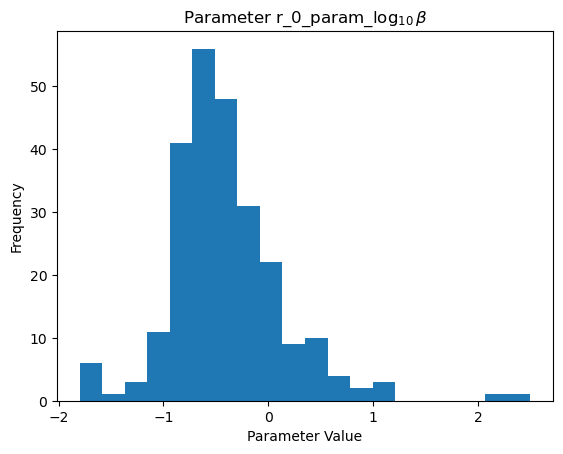

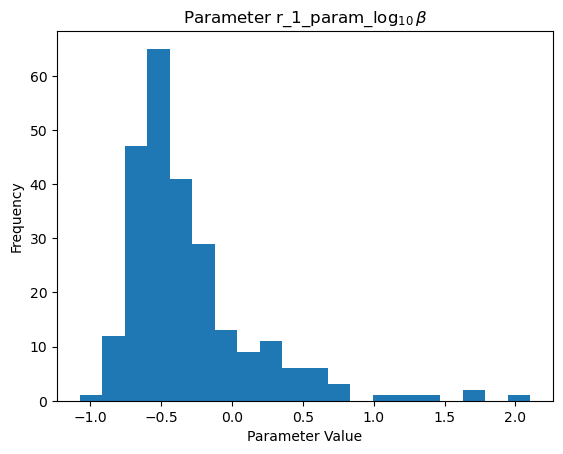

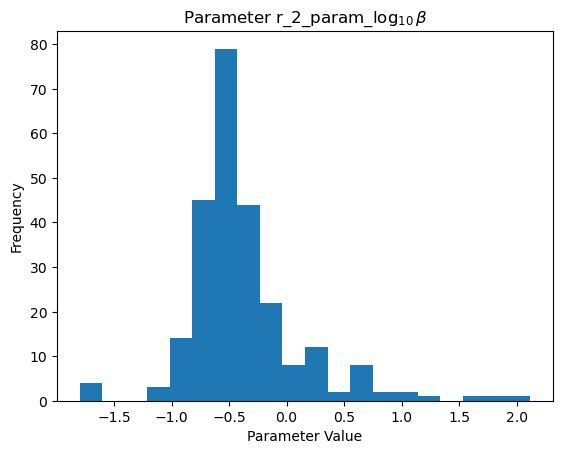

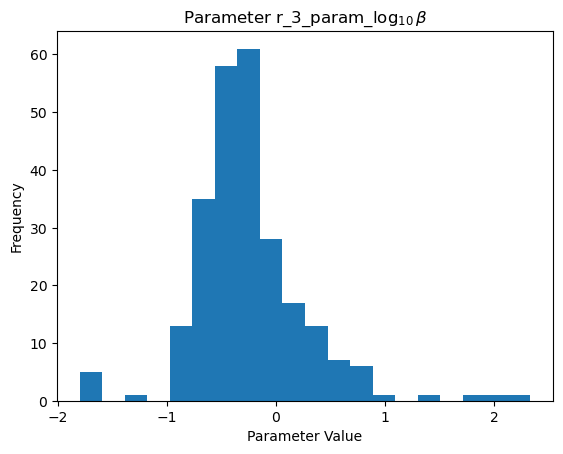

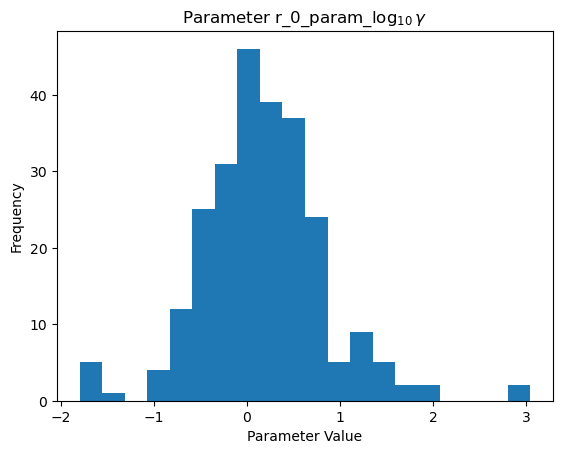

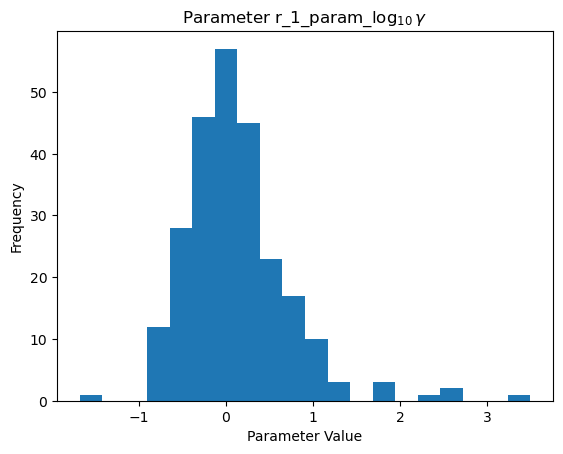

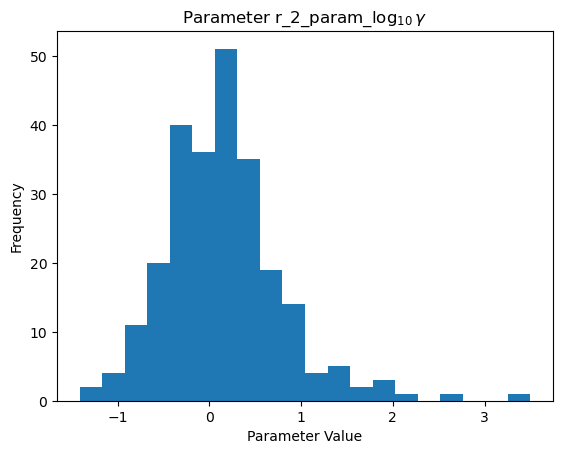

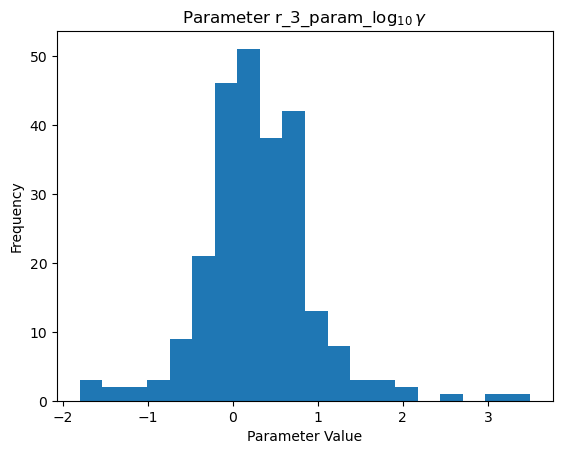

In [ ]:
param_names = [i for i in gaba_adata.var.keys() if 'param' in i]
for name in param_names:
    plt.hist(gaba_adata.var[name], bins=20)
    plt.title('Parameter ' + name[6:])
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')
    # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
    plt.show()

In [ ]:
# param_names = [i for i in gaba_adata.var.keys() if 'param' in i]
# for name in param_names:
#     plt.hist(gaba_adata.var[name], bins=20)
#     plt.title('Parameter ' + name[6:])
#     plt.xlabel('Parameter Value')
#     plt.ylabel('Frequency')
#     # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
#     plt.show()
#     # print(gaba_adata.var[name] - glu_adata.var[name])

## Plot parameter values against gene length.

# Analysis (to be implemented)

## Reject genes.

In [ ]:
# # Add rejection filter to adata.
gaba_adata = inference.reject_genes(gaba_adata, reject_at_bounds=False, mek_means=True, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)
glu_adata = inference.reject_genes(glu_adata, reject_at_bounds=False, mek_means=True, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)

# Show rejected genes.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'rejected' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'rejected' in i]])

# Show chi-squared values, and other rejection statistics if saved.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])

# # # Save chi-square values.
# chi_squareds_glu,  chi_squareds_gaba = glu_adata.var['csq'], gaba_adata.var['csq']

INFO:root:Chi-square computation complete. Rejected 41 genes out of 249. Runtime: 0.3 seconds.
INFO:root:Chi-square computation complete. Rejected 60 genes out of 249. Runtime: 0.4 seconds.
INFO:root:Chi-square computation complete. Rejected 36 genes out of 249. Runtime: 0.4 seconds.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 249. Runtime: 0.4 seconds.
INFO:root:Chi-square computation complete. Rejected 1 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-square computation complete. Rejected 1 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-square computation complete. Rejected 0 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-square computation complete. Rejected 3 genes out of 5. Runtime: 0.1 seconds.


,0_rejected_genes,1_rejected_genes,2_rejected_genes,3_rejected_genes
gene_name,,,,
Eif5b,False,False,False,False
Xrcc5,False,False,False,False
Klhl12,False,False,False,True
Rgs7,True,True,False,True
Thsd7b,False,False,False,True


,0_rejected_genes,1_rejected_genes,2_rejected_genes,3_rejected_genes
gene_name,,,,
AC149090.1,False,True,False,False
Arpc2,False,False,False,False
Adss,False,False,False,False
Map2,True,True,True,True
Eif5b,False,False,False,False
...,...,...,...,...
Kdm5c,False,True,False,False
Tbl1x,False,True,True,False
Fmr1,False,False,False,False


,0_csq,1_csq,2_csq,3_csq
gene_name,,,,
Eif5b,78.515135,5.373644e+01,0.188654,156.805446
Xrcc5,7.938545,4.184524e+01,0.000000,102.843128
Klhl12,81.890414,2.656669e-29,2.385356,975.653310
Rgs7,485.962478,4.226337e+02,0.000000,708.992284
Thsd7b,7.683852,4.315455e+02,0.300851,842.897960


,0_csq,1_csq,2_csq,3_csq
gene_name,,,,
AC149090.1,29.829603,59.355865,29.931372,34.999432
Arpc2,12.433538,30.947586,22.458747,15.354985
Adss,5.157823,18.088035,4.088068,4.854000
Map2,122.776740,117.833873,79.567279,97.793365
Eif5b,13.421872,20.814956,30.400026,9.803786
...,...,...,...,...
Kdm5c,7.575338,55.558320,12.024349,20.013778
Tbl1x,13.252894,71.436057,130.802360,14.492019
Fmr1,6.115560,3.937402,9.107186,8.065237


## Execute differential expression analysis.

In [ ]:
# If 2 anndata objects are given, parameters are compared across datasets.
if not mek_means_params:
    DE_genes, DE_filter, offs, residuals = analysis.DE_parameters(glu_adata, gaba_adata,
                                                              viz=True, use_sigma=True)

# If using meK-Means, compare clusters within one dataset.
else:
    DE_genes_gaba, DE_filter_gaba, offs_gaba, residuals_gaba = analysis.DE_parameters(gaba_adata,
                                                              viz=True, use_sigma=True, discard_rejected=True,
                                                                                     save_cluster_FCs=False)
    clusters = [i for i in DE_genes_gaba.keys()]
    DE_genes = [DE_genes_gaba[i] for i in clusters]
    param_names = gaba_adata.uns['search_result_list'][0].model.get_log_name_str()
    param_num, cluster_num = 0,0
    display(Markdown('E.g.' + param_names[param_num]))
    print(clusters[cluster_num], DE_genes[cluster_num][param_num])

display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'FC' in i]])

,"FC_$\log_{10} b$_(0, 1)","FC_$\log_{10} \beta$_(0, 1)","FC_$\log_{10} \gamma$_(0, 1)","FC_$\log_{10} b$_(2, 2)","FC_$\log_{10} \beta$_(2, 2)","FC_$\log_{10} \gamma$_(2, 2)","FC_$\log_{10} b$_(2, 3)","FC_$\log_{10} \beta$_(2, 3)","FC_$\log_{10} \gamma$_(2, 3)","FC_$\log_{10} b$_(1, 2)","FC_$\log_{10} \beta$_(1, 2)","FC_$\log_{10} \gamma$_(1, 2)"
gene_name,,,,,,,,,,,,
AC149090.1,NaN,NaN,NaN,0.0,0.0,0.0,-0.223198,0.127312,0.228976,NaN,NaN,NaN
Arpc2,0.432282,0.358257,0.119883,0.0,0.0,0.0,-0.366001,-0.087264,-0.151087,-0.174930,-0.100992,0.020495
Adss,-0.208500,-0.158407,-0.504466,0.0,0.0,0.0,-0.251745,-0.143975,0.044274,0.094382,0.143722,0.293943
Map2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eif5b,0.088425,0.223678,-0.071748,0.0,0.0,0.0,-0.336980,-0.026004,0.068318,-0.061128,-0.120044,-0.013334
...,...,...,...,...,...,...,...,...,...,...,...,...
Kdm5c,NaN,NaN,NaN,0.0,0.0,0.0,-0.174738,0.083469,0.080647,NaN,NaN,NaN
Tbl1x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fmr1,0.413010,0.358963,0.189431,0.0,0.0,0.0,-0.063256,0.306805,0.381231,0.035421,-0.064761,-0.019610


In [ ]:
# # NB changing loom to h5ad.
# adata_gaba = anndata.read_loom('monod_examples/sample_data/allen_C01_gaba.loom')
# adata_gaba.var_names = adata_gaba.var['gene_name']
# adata_gaba.obs_names = adata_gaba.obs['barcode']
# adata_gaba.obs = adata_gaba.obs.drop(columns=['barcode'])
# adata_gaba.var = adata_gaba.var.drop(columns=['gene_name'])
# adata_gaba.write('gaba_example.h5ad')

### Show some gene distributions.

[0 1 2]
Eif5b
Xrcc5
Klhl12


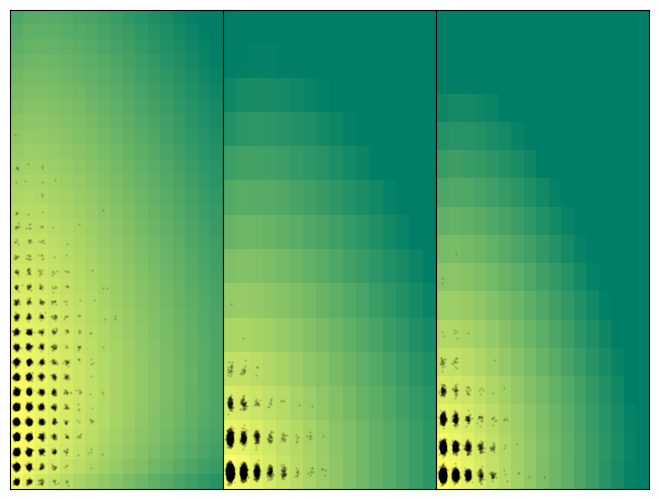

In [ ]:
fitted_adata = glu_adata

search_result, search_data = fitted_adata.uns['search_result'], fitted_adata.uns['search_data']
logscale = True

sz =(1,3)
(nrows, ncols) = sz
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols)

nax = np.prod(sz)

genes_to_plot = np.arange(nax)

genes_to_plot = np.asarray(genes_to_plot)
if genes_to_plot.dtype == bool:
    gtp_temp = np.arange(self.n_genes)
    genes_to_plot = gtp_temp[genes_to_plot]

number_of_genes_to_plot = len(genes_to_plot)
if number_of_genes_to_plot > 5:
    number_of_genes_to_plot = 5
    genes_to_plot = genes_to_plot[: 5]
if number_of_genes_to_plot > nax:  # This should no longer break...
    number_of_genes_to_plot = nax
    genes_to_plot = genes_to_plot[:nax]

j_ = 0
marg = 'joint'
modalities = ['spliced', 'unspliced']

print(genes_to_plot)
for i_ in genes_to_plot:
    lm = np.copy(search_data.M[:, i_])

    # TODO: generalize by adding attribute names as attribute of e.g. CMEModel
    # attributes = ['unspliced', 'spliced', 'protein']

    num_modalities = 2
    for i in range(num_modalities):
        if marg == modalities[i]:
            lm[:i] = 1
            lm[i+1:]=1

    axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_

    samp = search_result.regressor_optimum[i_]
    Pa = np.squeeze(search_result.model.eval_model_pss(search_result.phys_optimum[i_], lm, samp))
    layers = np.array([i.copy() for i in search_data.layers])

    marg = 'joint'
    if marg == "joint":
        if logscale:
            Pa[Pa < 1e-10] = 1e-10
            Pa = np.log10(Pa)

        if num_modalities==2:
            ax1[axloc].imshow(Pa.T, aspect="auto", cmap="summer")
        elif num_modalities==3:
            ax1[axloc].imshow(Pa.sum(axis=2).T, aspect="auto", cmap="summer")
        else:
            log.error('Joint distribution plot only implemented for 2 or 3 modalities')

        ax1[axloc].invert_yaxis()

        jitter_magn = 0.1
        jitter = np.random.randn(2, search_result.n_cells) * jitter_magn
        ax1[axloc].scatter(
            *layers[:2, :,i_] + jitter, c="k", s=1, alpha=0.1
        )

        ax1[axloc].set_xlim([-0.5, search_data.M[0, i_] - 1.5])
        ax1[axloc].set_ylim([-0.5, search_data.M[1, i_] - 1.5])
    else:
        plot_hist_and_fit(ax1[axloc], search_data, i_, Pa, marg)
        if logscale:
            ax1[axloc].set_yscale("log")

    print(search_result.gene_names[i_])
    # if title:
    #     titlestr = search_result.gene_names[i_]
    #     if hasattr(search_result, "rejected_genes") and search_result.rejected_genes[i_]:
    #         titlestr += " (rej.)"
    #     ax1[axloc].set_title(titlestr, fontdict={"fontsize": 9})
    ax1[axloc].set_xticks([])
    ax1[axloc].set_yticks([])
    j_ += 1
fig1.tight_layout(pad=0.02)


/home/cat/monod/src/monod/inference.py:1302: RuntimeWarning: divide by zero encountered in divide
  dx = (np.asarray(self.sp.samp_ub) - np.asarray(self.sp.samp_lb)) / (
/home/cat/monod/src/monod/inference.py:1312: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  lnd = ax.imshow(


INFO:root:Figure stored to new_gaba/Bursty_Poisson_1x1/analysis_figures/kldiv.png.
[0 1 2 3 4]
INFO:root:Figure stored to new_gaba/Bursty_Poisson_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.1 seconds.
INFO:root:Figure stored to new_gaba/Bursty_Poisson_1x1/analysis_figures/subsampling.png.
INFO:root:Figure stored to new_gaba/Bursty_Poisson_1x1/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.80, -1.50.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.1 seconds.
INFO:root:New optimum: -6.80, -1.50.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Run

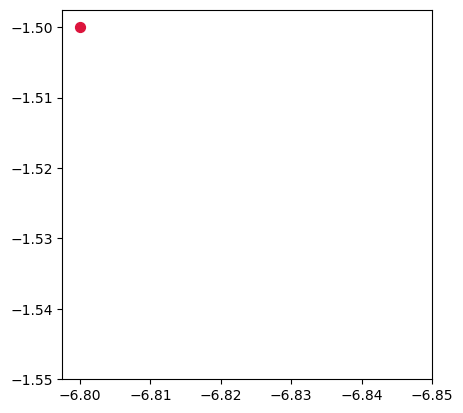

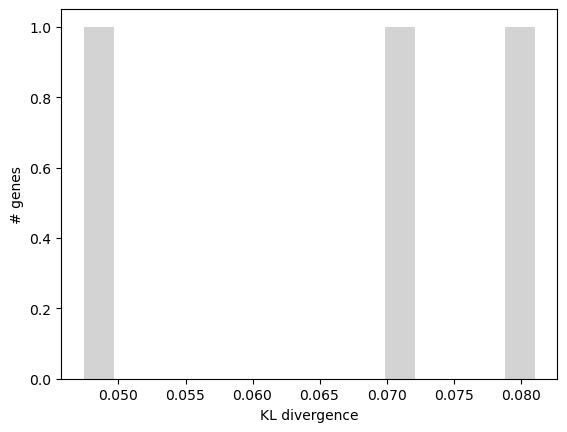

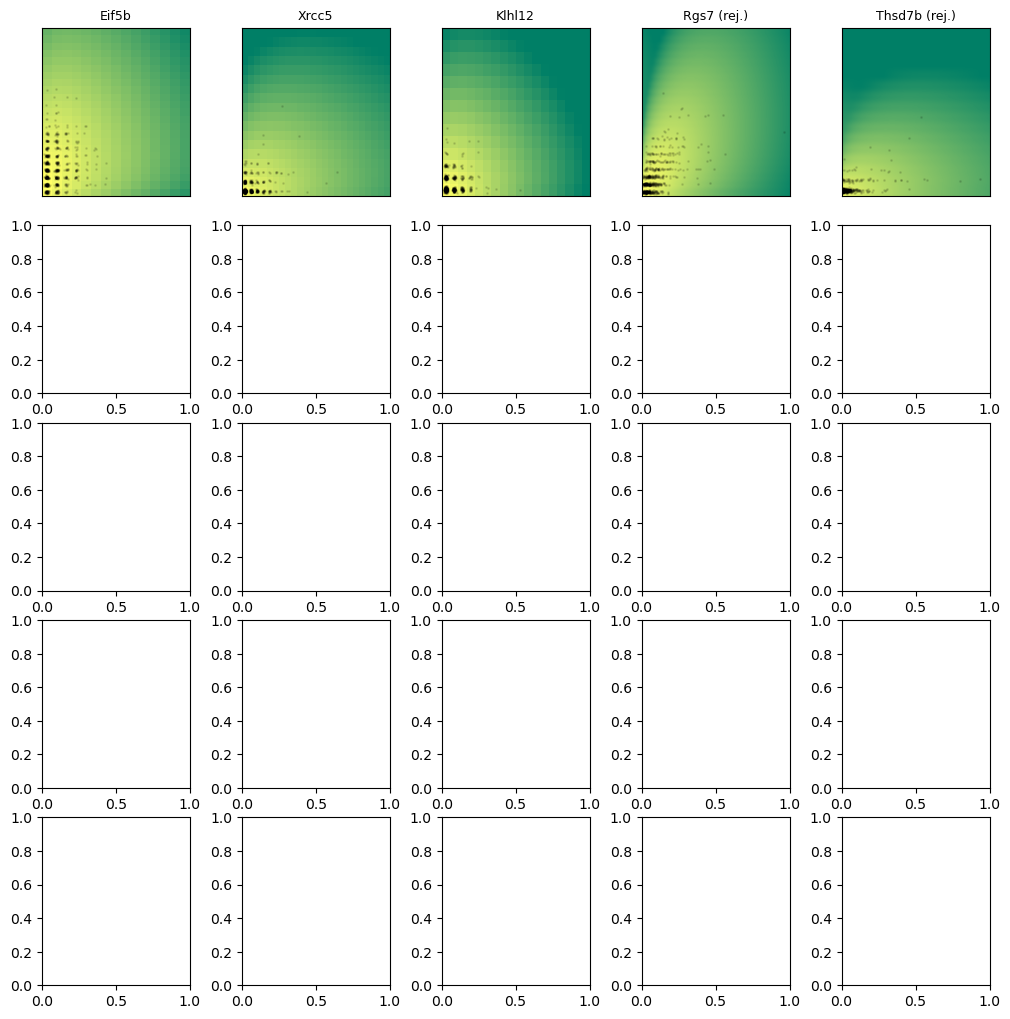

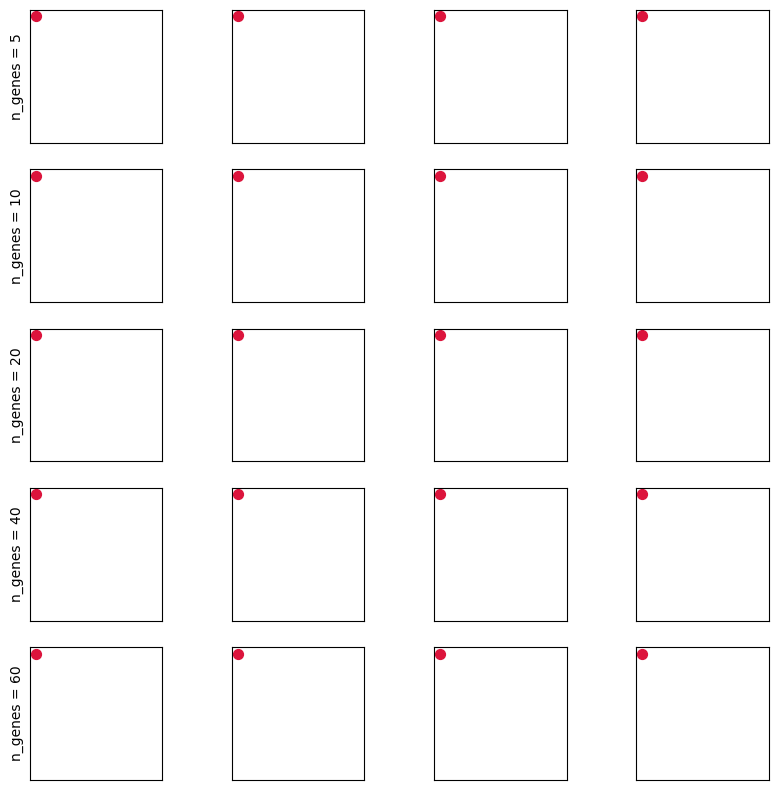

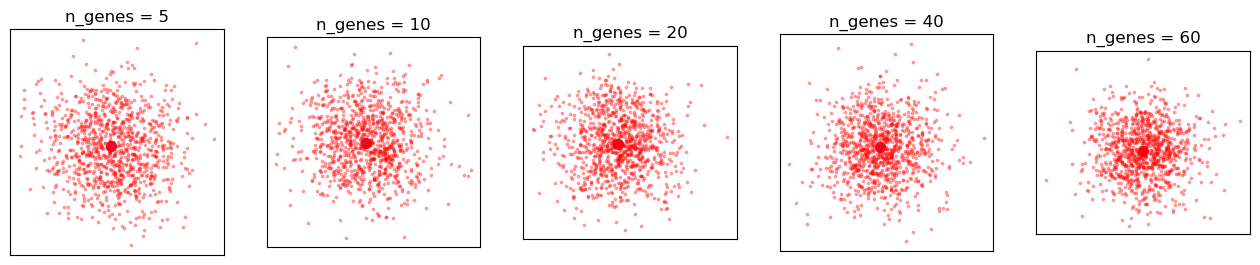

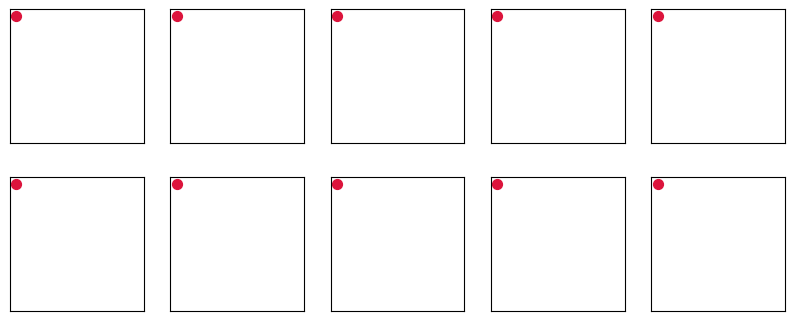

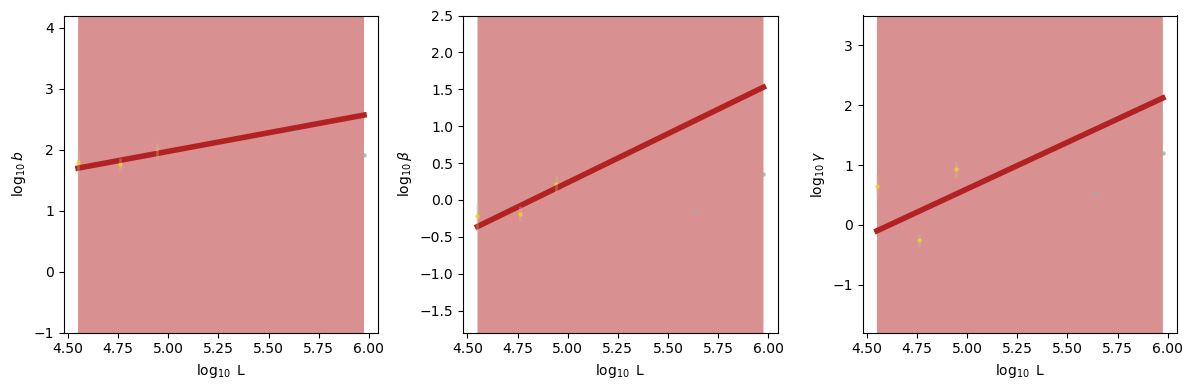

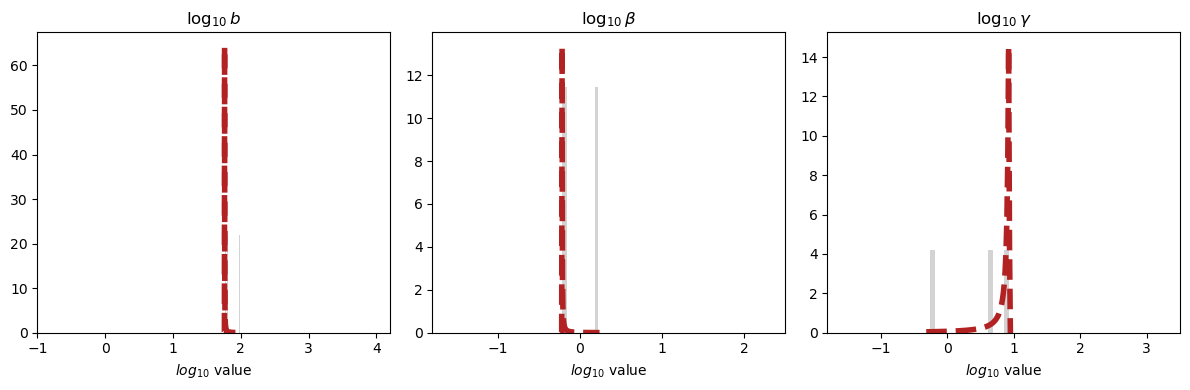

In [ ]:
analysis.run_qc(gaba_adata)